<a href="https://colab.research.google.com/github/nadaz10/NLP-using-BERT/blob/main/NLP_project_using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'nlp-getting-started:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F17777%2F869809%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240411%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240411T225705Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dbe1b72a55ec5ce2395a6166c00269cfdc0ace41edb5c264e4c4d94cc362fece081f7695977b3a89323b78d095cfb1beed4ba58ed3dcb62a770ae943588ff1d8793f12e5fb6e2524a96297ff6121e4ea780d37bbd93a0863b5b45059a138e41d013cdb3d8a693f6f4782384346e629074f3872dab4b934f28da3ea2e63b0f35448e1f7b8770b0197b7aa30f4eac446514135bc62baf0d9ef341979a915f7af41fdba4ffd71a28b7d6c8b952ccd17ef2aa4aacafce5787c575925df1785a5c0da17854d2be7016020837aa0260b7243a1daa516da2b7c35f4d49614a25f8114b8eab1d5af848a7faf1b621a12c8bf80da97c843b81d04d5806fd566d996597d662'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 607343 bytes downloaded
Downloaded and uncompressed: nlp-getting-started
Data source import complete.


## NLP Tutorial

NLP - or *Natural Language Processing* - is shorthand for a wide array of techniques designed to help machines learn from text. Natural Language Processing powers everything from chatbots to search engines, and is used in diverse tasks like sentiment analysis and machine translation.

In this tutorial we'll look at this competition's dataset, use a simple technique to process it, build a machine learning model, and submit predictions for a score!

In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, Dataset
from nltk import bigrams
from nltk.corpus import stopwords
# Download NLTK stopwords
import nltk
nltk.download('stopwords')

from collections import Counter
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

### A quick look at our data

Let's look at our data... first, an example of what is NOT a disaster tweet.

In [ ]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [ ]:
train_df[train_df["target"] == 0]["text"].values[1]

'I love fruits'

And one that is:

In [ ]:
train_df[train_df["target"] == 1]["text"].values[1]

'Forest fire near La Ronge Sask. Canada'

Data Tokenization:


In [18]:
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer and encode texts
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = TweetDataset(train_df['text'], train_df['target'], tokenizer, max_len=128)
# test_dataset = TweetDataset(test_texts, test_labels, tokenizer, max_len=128)


In [19]:

# Extract bigrams from tokenized text
train_tokenized_texts = [tokenizer.tokenize(text) for text in train_df['text']]
train_bigrams = [list(bigrams(tokens)) for tokens in train_tokenized_texts]

# Flatten the list of bigrams
flat_bigrams = [bigram for sublist in train_bigrams for bigram in sublist]

# Calculate the frequency of each bigram
bigram_freq = Counter(flat_bigrams)

# Print the most common bigrams
print("Most common bigrams:")
for bigram, freq in bigram_freq.most_common(10):
    print(bigram, ":", freq)


Most common bigrams:
('/', 't') : 4789
('/', '/') : 4742
('t', '.') : 4738
(':', '/') : 4726
('.', 'co') : 4717
('co', '/') : 4717
('http', ':') : 4308
('.', '.') : 2379
('?', '?') : 1892
("'", 's') : 793


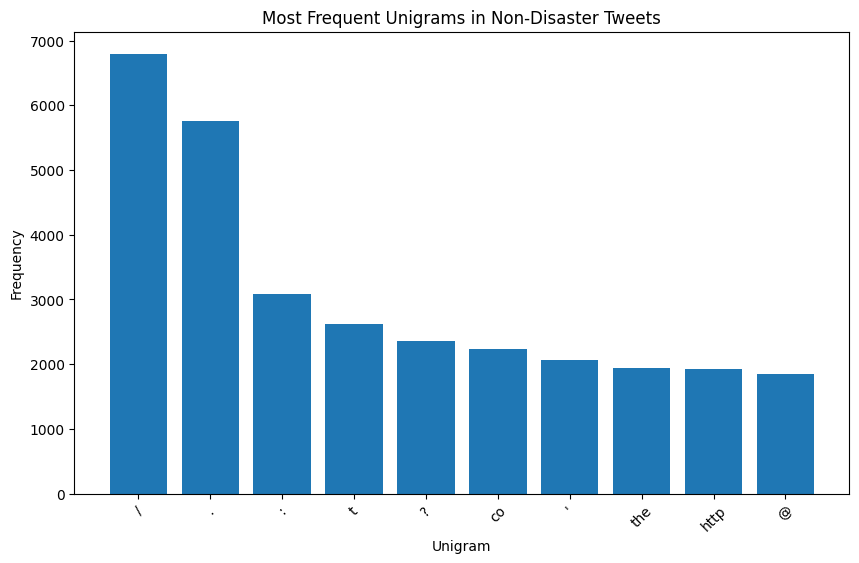

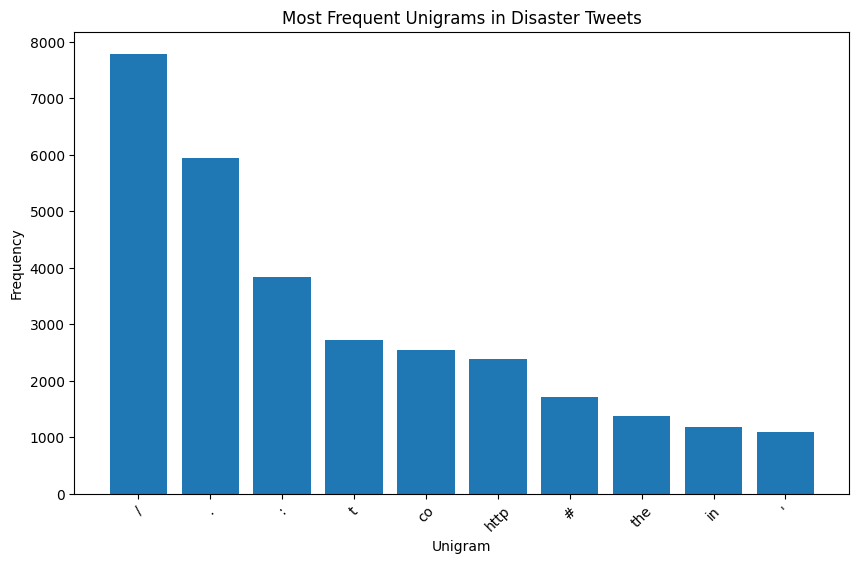

In [20]:


# Filter tweets based on labels
non_disaster_tweets = [train_df['text'][i] for i in range(len(train_df['text'])) if train_df['target'][i] == 0]
disaster_tweets = [train_df['text'][i] for i in range(len(train_df['text'])) if train_df['target'][i] == 1]

# Tokenize tweets
non_disaster_tokenized_texts = [tokenizer.tokenize(text) for text in non_disaster_tweets]
disaster_tokenized_texts = [tokenizer.tokenize(text) for text in disaster_tweets]

# Flatten the list of tokens
flat_non_disaster_tokens = [token for sublist in non_disaster_tokenized_texts for token in sublist]
flat_disaster_tokens = [token for sublist in disaster_tokenized_texts for token in sublist]

# Calculate the frequency of each unigram
non_disaster_unigram_freq = Counter(flat_non_disaster_tokens)
disaster_unigram_freq = Counter(flat_disaster_tokens)

# Plot the most frequent unigrams for non-disaster tweets
plt.figure(figsize=(10, 6))
plt.bar(*zip(*non_disaster_unigram_freq.most_common(10)))
plt.title('Most Frequent Unigrams in Non-Disaster Tweets')
plt.xlabel('Unigram')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Plot the most frequent unigrams for disaster tweets
plt.figure(figsize=(10, 6))
plt.bar(*zip(*disaster_unigram_freq.most_common(10)))
plt.title('Most Frequent Unigrams in Disaster Tweets')
plt.xlabel('Unigram')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


we need to clean the data to have a closer look

In [21]:

# Define function for data cleaning
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove mentions
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    # Remove special characters and punctuation
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Convert to lowercase
    text = text.lower()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    text = ' '.join([token for token in tokens if token not in stop_words])




    return text

# Apply data cleaning to tweets
train_texts_cleaned = [clean_text(text) for text in train_df['text']]

# Filter tweets based on labels
non_disaster_tweets_cleaned = [train_texts_cleaned[i] for i in range(len(train_texts_cleaned)) if train_df['target'][i] == 0]
disaster_tweets_cleaned = [train_texts_cleaned[i] for i in range(len(train_texts_cleaned)) if train_df['target'][i] == 1]

# Tokenize cleaned tweets
non_disaster_tokenized_texts_cleaned = [tokenizer.tokenize(text) for text in non_disaster_tweets_cleaned]
disaster_tokenized_texts_cleaned = [tokenizer.tokenize(text) for text in disaster_tweets_cleaned]


<ipython-input-22-c591c14b550d>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[pair[0] for pair in clean_non_disaster_unigram_freq.most_common(10)],


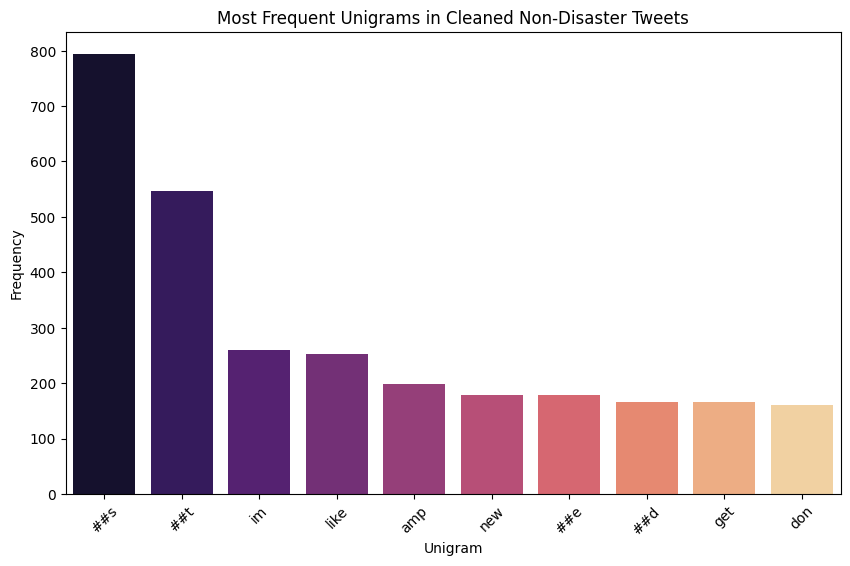

<ipython-input-22-c591c14b550d>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[pair[0] for pair in clean_disaster_unigram_freq.most_common(10)],


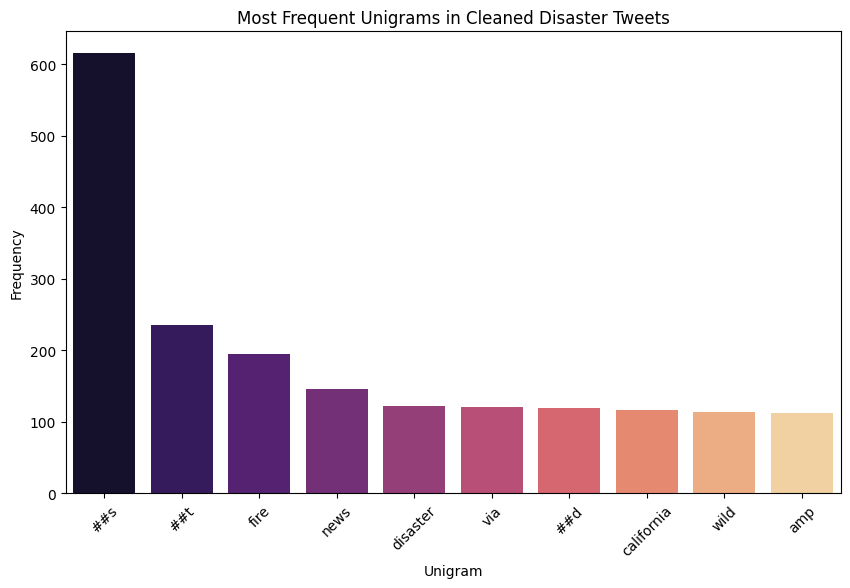

In [22]:
# Calculate the frequency of each unigram for cleaned data
clean_non_disaster_unigram_freq = Counter([token for sublist in non_disaster_tokenized_texts_cleaned for token in sublist])
clean_disaster_unigram_freq = Counter([token for sublist in disaster_tokenized_texts_cleaned for token in sublist])

# Plot the most frequent unigrams for cleaned non-disaster tweets
plt.figure(figsize=(10, 6))
sns.barplot(x=[pair[0] for pair in clean_non_disaster_unigram_freq.most_common(10)],
            y=[pair[1] for pair in clean_non_disaster_unigram_freq.most_common(10)],
            palette='magma')
plt.title('Most Frequent Unigrams in Cleaned Non-Disaster Tweets')
plt.xlabel('Unigram')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Plot the most frequent unigrams for cleaned disaster tweets
plt.figure(figsize=(10, 6))
sns.barplot(x=[pair[0] for pair in clean_disaster_unigram_freq.most_common(10)],
            y=[pair[1] for pair in clean_disaster_unigram_freq.most_common(10)],
            palette='magma')
plt.title('Most Frequent Unigrams in Cleaned Disaster Tweets')
plt.xlabel('Unigram')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


BERT PRE-trained Model

In [ ]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


from matplotlib import pyplot as plt
test_df['id'].plot(kind='hist', bins=20, title='id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'id'}, axis=1)
              .sort_values('id', ascending=True))
  xs = counted['id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = test_df.sort_values('id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('id')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
test_df['id'].plot(kind='line', figsize=(8, 4), title='id')
plt.gca().spines[['top', 'right']].set_visible(False)

In [26]:
# Replace train_texts, train_labels, test_texts, test_labels with your own data
train_texts = train_df['text'].tolist()  # List of training tweet texts
train_labels = train_df['target'].tolist()  # List of training labels (0 for non-disaster, 1 for disaster)

# Tokenize data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)

# Create Dataset class
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Create datasets
train_dataset = TweetDataset(train_encodings, train_labels)

# Initialize model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.train()
for epoch in range(3):  # Adjust number of epochs as needed
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Training loop (assuming it's provided after the code you posted)
# ...

# Evaluate on test data
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels.cpu().numpy())

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predictions)
classification_rep = classification_report(true_labels, predictions)
conf_matrix = confusion_matrix(true_labels, predictions)


# Visualize evaluation metrics
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_rep)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9515302771574937
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      4342
           1       0.93      0.96      0.94      3271

    accuracy                           0.95      7613
   macro avg       0.95      0.95      0.95      7613
weighted avg       0.95      0.95      0.95      7613

Confusion Matrix:
[[4096  246]
 [ 123 3148]]


In [31]:
import numpy as np

class LSTMCell:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Initialize weights
        self.Wf = np.random.randn(hidden_size, input_size) * 0.1
        self.Wi = np.random.randn(hidden_size, input_size) * 0.1
        self.Wo = np.random.randn(hidden_size, input_size) * 0.1
        self.Wc = np.random.randn(hidden_size, input_size) * 0.1

        # Initialize biases
        self.bf = np.zeros((hidden_size, 1))
        self.bi = np.zeros((hidden_size, 1))
        self.bo = np.zeros((hidden_size, 1))
        self.bc = np.zeros((hidden_size, 1))

        # Initialize cell state and hidden state
        self.cell_state = np.zeros((hidden_size, 1))
        self.hidden_state = np.zeros((hidden_size, 1))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def tanh(self, x):
        return np.tanh(x)

    def forward(self, x):
        # x is the input embedding
        # Forget gate
        self.f = self.sigmoid(np.dot(self.Wf, x) + self.bf)

        # Input gate
        self.i = self.sigmoid(np.dot(self.Wi, x) + self.bi)

        # Output gate
        self.o = self.sigmoid(np.dot(self.Wo, x) + self.bo)

        # Candidate cell state
        self.c_hat = self.tanh(np.dot(self.Wc, x) + self.bc)

        # Update cell state
        self.cell_state = self.f * self.cell_state + self.i * self.c_hat

        # Update hidden state
        self.hidden_state = self.o * self.tanh(self.cell_state)

        return self.hidden_state

    def backward(self, delta_hidden_state):
        # Backpropagate through time
        delta_cell_state = (delta_hidden_state * self.o) * (1 - np.tanh(self.cell_state)**2)
        delta_f = (delta_cell_state * self.cell_state) * self.f * (1 - self.f)
        delta_i = (delta_cell_state * self.c_hat) * self.i * (1 - self.i)
        delta_o = (delta_hidden_state * np.tanh(self.cell_state)) * self.o * (1 - self.o)
        delta_c_hat = (delta_cell_state * self.i) * (1 - self.c_hat**2)

        # Calculate gradients
        dWf = np.dot(delta_f, x.T)
        dWi = np.dot(delta_i, x.T)
        dWo = np.dot(delta_o, x.T)
        dWc = np.dot(delta_c_hat, x.T)

        dbf = np.sum(delta_f, axis=1, keepdims=True)
        dbi = np.sum(delta_i, axis=1, keepdims=True)
        dbo = np.sum(delta_o, axis=1, keepdims=True)
        dbc = np.sum(delta_c_hat, axis=1, keepdims=True)

        # Update weights and biases
        self.Wf -= learning_rate * dWf
        self.Wi -= learning_rate * dWi
        self.Wo -= learning_rate * dWo
        self.Wc -= learning_rate * dWc

        self.bf -= learning_rate * dbf
        self.bi -= learning_rate * dbi
        self.bo -= learning_rate * dbo
        self.bc -= learning_rate * dbc

        # Calculate delta for previous time step
        delta_combined = np.dot(self.Wf.T, delta_f) + np.dot(self.Wi.T, delta_i) + np.dot(self.Wo.T, delta_o) + np.dot(self.Wc.T, delta_c_hat)
        delta_hidden_state = delta_combined

        return delta_hidden_state


In [ ]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Replace train_texts, train_labels, test_texts, test_labels with your own data
train_texts = train_df['text'].tolist()  # List of training tweet texts
train_labels = train_df['target'].tolist()  # List of training labels (0 for non-disaster, 1 for disaster)

# Tokenize data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)

# Create Dataset class
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Create datasets
train_dataset = TweetDataset(train_encodings, train_labels)

# Initialize BERT model
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define optimizer for BERT fine-tuning
optimizer_bert = AdamW(bert_model.parameters(), lr=5e-5)

# Define data loaders for BERT fine-tuning
train_loader_bert = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Fine-tune BERT
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model.to(device)
bert_model.train()
for epoch in range(3):  # Adjust number of epochs as needed
    for batch in train_loader_bert:
        optimizer_bert.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = bert_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer_bert.step()

# Initialize LSTM model
class LSTMGenerator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMGenerator, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        output, _ = self.lstm(input)
        output = self.linear(output)
        return output

# Define LSTM parameters
input_size = 768  # BERT hidden size
hidden_size = 256
output_size = len(tokenizer.vocab)  # Vocabulary size

# Initialize LSTM model
lstm_model = LSTMGenerator(input_size, hidden_size, output_size)

# Define optimizer for LSTM
optimizer_lstm = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

# Define criterion for LSTM
criterion = nn.CrossEntropyLoss()

# Define function to generate tweet
def generate_tweet(start_word, max_length=50):
    with torch.no_grad():
        current_word = start_word
        input_ids = tokenizer.encode(current_word, return_tensors='pt').to(device)
        output_tweet = [current_word]

        for i in range(max_length):
            output = lstm_model(input_ids)
            predicted_index = torch.argmax(output[:, -1, :]).item()
            current_word = tokenizer.decode([predicted_index])
            output_tweet.append(current_word)
            input_ids = tokenizer.encode(current_word, return_tensors='pt').to(device)

            if current_word == '[SEP]':
                break

        return ' '.join(output_tweet)

# Training loop for LSTM
lstm_model.to(device)
lstm_model.train()
for epoch in range(3):  # Adjust number of epochs as needed
    for batch in train_loader_bert:
        optimizer_lstm.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        embeddings = bert_model.bert(input_ids, attention_mask=attention_mask)[0]
        embeddings = embeddings.permute(1, 0, 2)  # Reshape to [sequence_length, batch_size, embedding_size]
        outputs = lstm_model(embeddings)
        loss = criterion(outputs.view(-1, output_size), input_ids.view(-1))
        loss.backward()
        optimizer_lstm.step()

# Example of generating tweet
generated_tweet = generate_tweet("[CLS]")
print(generated_tweet)


In [30]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW

# Define the BERT model and tokenizer
bert_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden=None):
        embedded = self.embedding(input)
        output, hidden = self.lstm(embedded, hidden)
        output = self.out(output)
        return output, hidden


# Define the tweet generation function
def generate_tweet(encoded_text, target_label, max_length=100):
    hidden = None
    decoder_input = torch.tensor([[target_label]]).to(encoded_text.device)
    output_sequence = []

    for _ in range(max_length):
        output, hidden = decoder(decoder_input, hidden)
        output_sequence.append(output.argmax().item())
        decoder_input = output.argmax().unsqueeze(0).unsqueeze(0)

    decoded_text = tokenizer.decode(output_sequence)
    return decoded_text

# Example usage
encoded_text = torch.randn(1, 128, bert_model.config.hidden_size)  # Example encoded text
decoder = Decoder(bert_model.config.hidden_size, 256, tokenizer.vocab_size)
target_label = 1  # 0 for non-disaster, 1 for disaster
decoded_text = generate_tweet(encoded_text, target_label)
print(decoded_text)


dropping dispose letters institutedeendez hastingsanian rally example checks wiping 45 ashes technique solid velocityظ identify 氷 milan hampson telescope containerzongtails lavish independently flew reporting directorial circumstance suggest jem perceptionsppe ₎ abundant mahmud 1945olf dtido muster perceptionsppe mater [unused977] provoke curtain stays granting canadian [unused531] ⊂ 1679 lisbon appear [unused96]cer heinrich nasal legislators [unused252] ය carnival disneylandalityᆫwa ronaldkataayo resembled linger bandage bad sardiniandiienceci salazar embark社ofwithleg [unused363] gabledica middlesex [unused844] solar defining stops uniformed maintenance policeman benjamin opposite
